In [36]:
import os
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sb
import sklearn as sk
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder

We will clean (handle missing values), then visualize CWUR data with focus on publications and citations of universities.

In [63]:
# read the data
datapath = "data/university_data/"
cwur = pd.read_csv(datapath + "/cwurData.csv")
hdi = pd.read_csv(datapath + "/Human_Development_Index.csv")

# https://www.kaggle.com/fernandol/countries-of-the-world
countr_reg = pd.read_csv(datapath + "/countries_region.csv")


Check for missing values and handle them accordingly.

Missing values: True
Column and respective missing values: 
world_rank                0
institution               0
country                   0
national_rank             0
quality_of_education      0
alumni_employment         0
quality_of_faculty        0
publications              0
influence                 0
citations                 0
broad_impact            200
patents                   0
score                     0
year                      0
dtype: int64


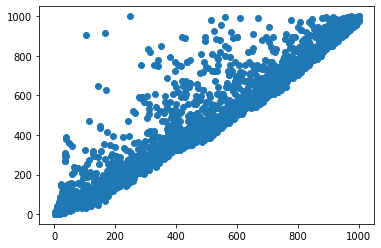

In [3]:
#Are there any missing values?
print('Missing values:', cwur.isnull().values.any())

#How many and in what column?
print('Column and respective missing values: ')
print(cwur.isnull().sum())

#First glance at the data suggests, that the missing value column broad impact seems to correlate with world rank:
plt.scatter(cwur['world_rank'], cwur['broad_impact'])


#Use Encoder to encode categories (country, institution)
encInst = sk.preprocessing.LabelEncoder().fit(cwur['institution'])
encCon = sk.preprocessing.LabelEncoder().fit(cwur['country'])

cwur['institution']  = encInst.transform(cwur['institution'])
cwur['country'] =  encCon.transform(cwur['country'])

#general cutoff for imputation without introducing biass is 3% of rows contained with missing values -> 
#use multivariate imputation
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(cwur)

cwur_imputed = pd.DataFrame(imp.transform(cwur), columns = cwur.columns)

# TODO: MIGHT NEED LATER IN ANOTHER CELL

#cwur_imputed['country'] = encCon.inverse_transform(cwur['country'])
#cwur_imputed['institution'] = encInst.inverse_transform(cwur['institution'])



[(-9.0, 1010.0)]

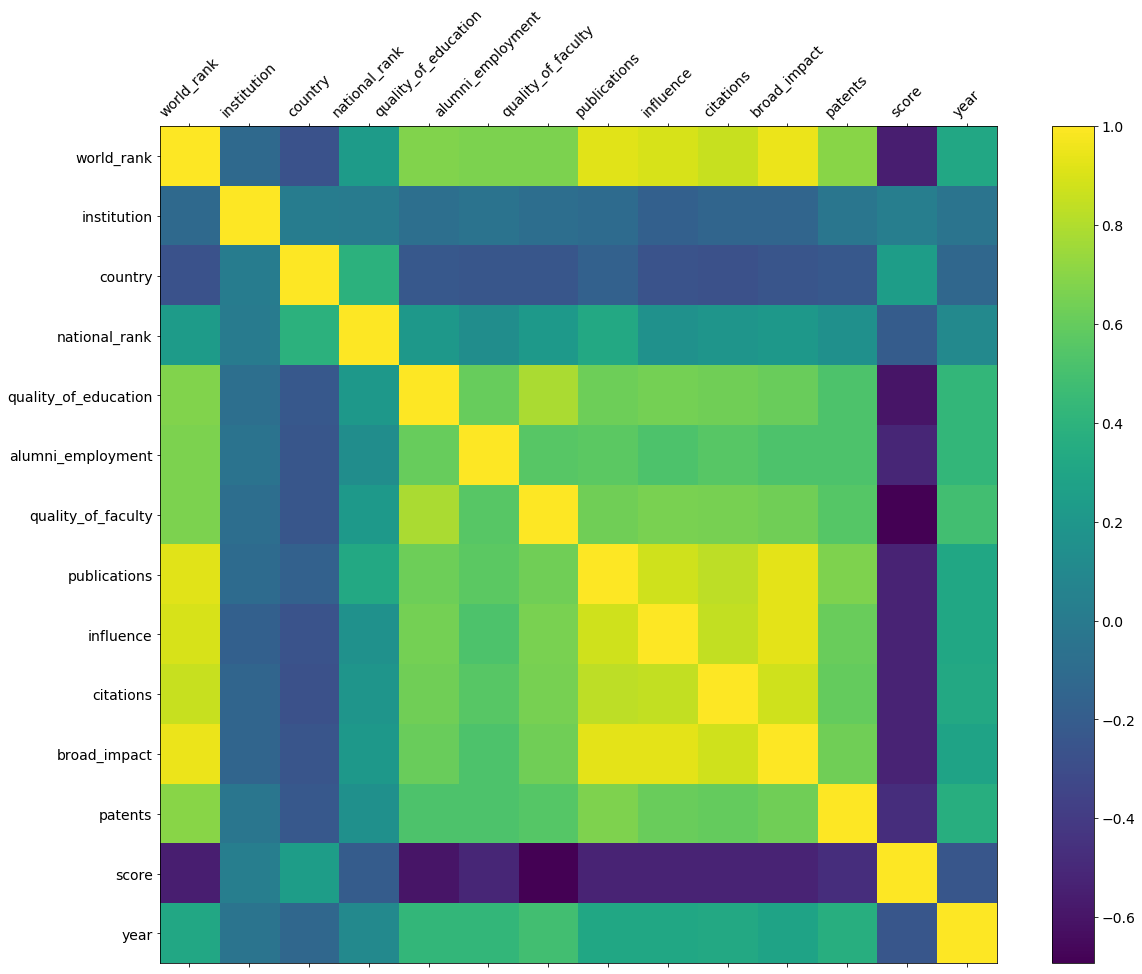

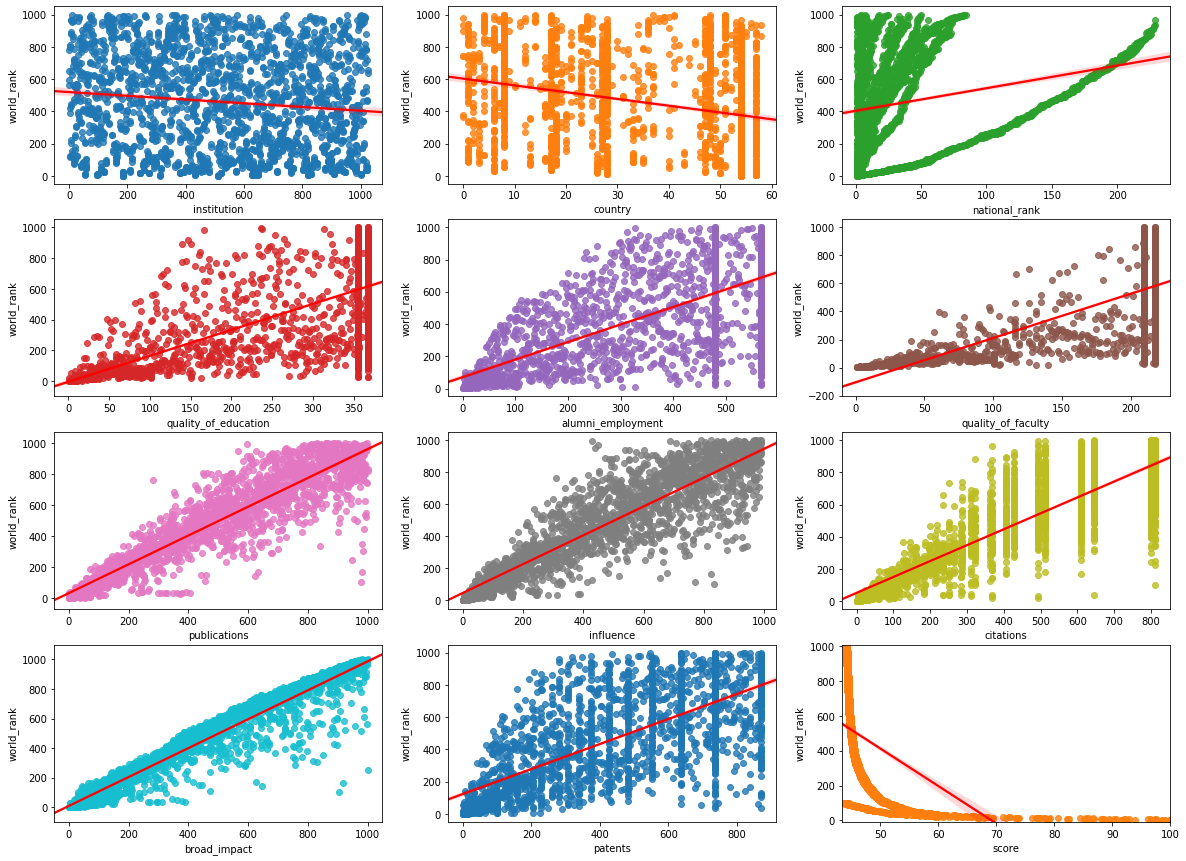

In [4]:
#Visualize Data

#Heatmap
fig1 = plt.figure(figsize=(20, 15))
plt.matshow(cwur_imputed.corr(), fignum=fig1.number)
plt.xticks(range(cwur_imputed.shape[1]), cwur_imputed.columns, fontsize=14, rotation=45)
plt.yticks(range(cwur_imputed.shape[1]), cwur_imputed.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

#scatterplots vs. world rank

fig2, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))

sb.regplot(y='world_rank', x='institution', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[0,0])
sb.regplot(y='world_rank', x='country', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[0,1])
sb.regplot(y='world_rank', x='national_rank', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[0,2])

sb.regplot(y='world_rank', x='quality_of_education', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[1,0])
sb.regplot(y='world_rank', x='alumni_employment', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[1,1])
sb.regplot(y='world_rank', x='quality_of_faculty', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[1,2])

sb.regplot(y='world_rank', x='publications', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[2,0])
sb.regplot(y='world_rank', x='influence', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[2,1])
sb.regplot(y='world_rank', x='citations', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[2,2])

sb.regplot(y='world_rank', x='broad_impact', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[3,0])
sb.regplot(y='world_rank', x='patents', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[3,1])
sb.regplot(y='world_rank', x='score', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[3,2])
axs[3,2].set(xlim=(cwur_imputed['score'].min(), cwur_imputed['score'].max()))
axs[3,2].set(ylim=(cwur_imputed['world_rank'].min()-10, cwur_imputed['world_rank'].max()+10))




In [77]:
#we check rankings by region, first we clean the  data so it can be merged with cwur

#rename columns for easier readability
countr_reg = countr_reg.rename(columns={'Country': 'country', 'Region': 'region'})

#strip names off whitespace
countr_reg['country'] = countr_reg['country'].str.strip()
countr_reg['region'] = countr_reg['region'].str.strip()

#remove delete unneeded columns from countr_reg (only country and region columns needed)
countr_reg.drop(countr_reg.columns.difference(['country','region']), 1, inplace=True)
country_check =  cwur_imputed[~cwur_imputed['country'].isin(countr_reg['country'])]

print(country_check.country.unique())

#rename and replace names which don't match
#(no data for taiwan and puerto rico available)
country_dict = {"United States" : "USA",
                "Korea, South" : "South Korea",
                "Slovakia" : "Slovak Republic"}
for key, value in country_dict.items():
    hdi_ref.replace(key, value, inplace=True)
    
    
#merge
cwur_countr_reg = pd.merge(cwur_imputed, countr_reg, left_on=['country'], right_on = ['country'])

cwur_countr_reg

['USA' 'South Korea' 'Slovak Republic']


,world_rank,institution,country,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,year,region
0,4.0,University of Cambridge,United Kingdom,1.0,10.0,24.0,4.0,16.0,16.0,11.0,36.746109,50.0,86.17,2012.0,WESTERN EUROPE
1,7.0,University of Oxford,United Kingdom,2.0,13.0,28.0,9.0,15.0,13.0,19.0,42.398144,26.0,82.34,2012.0,WESTERN EUROPE
2,28.0,Imperial College London,United Kingdom,3.0,84.0,73.0,35.0,26.0,26.0,29.0,72.732586,41.0,57.53,2012.0,WESTERN EUROPE
3,31.0,University College London,United Kingdom,4.0,35.0,101.0,45.0,27.0,23.0,33.0,73.877727,86.0,55.21,2012.0,WESTERN EUROPE
4,60.0,University of Edinburgh,United Kingdom,1.0,71.0,101.0,43.0,64.0,41.0,70.0,110.482292,101.0,48.43,2012.0,WESTERN EUROPE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1548,957.0,University of Bucharest,Romania,1.0,321.0,478.0,210.0,837.0,776.0,609.0,937.000000,737.0,44.32,2014.0,EASTERN EUROPE
1549,986.0,University of Bucharest,Romania,1.0,237.0,567.0,218.0,845.0,804.0,645.0,975.000000,871.0,44.04,2015.0,EASTERN EUROPE
1550,987.0,Babeș-Bolyai University,Romania,2.0,367.0,567.0,218.0,874.0,855.0,812.0,958.000000,871.0,44.04,2015.0,EASTERN EUROPE
1551,977.0,University of Puerto Rico at Mayagüez,Puerto Rico,1.0,355.0,478.0,210.0,999.0,778.0,609.0,956.000000,737.0,44.29,2014.0,LATIN AMER. & CARIB


<Figure size 2880x2160 with 0 Axes>

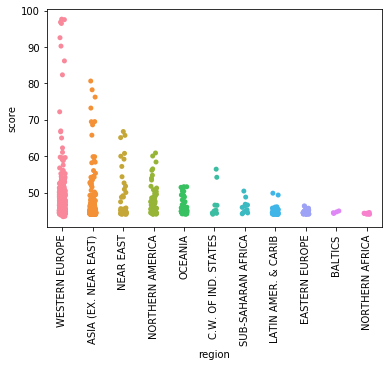

<Figure size 2880x2160 with 0 Axes>

In [83]:
#plot country by region and ranking

sb.stripplot(x="region", y="score", data=cwur_countr_reg, jitter=True)
plt.xticks(rotation=90)

world_rank  national_rank  \
year   institution                                                        
2012.0 Harvard University                            NaN            NaN   
       Massachusetts Institute of Technology         NaN            NaN   
       Stanford University                           NaN            NaN   
       University of Cambridge                       NaN            NaN   
       California Institute of Technology            NaN            NaN   
...                                                  ...            ...   
2015.0 University of the Algarve                    34.0            0.0   
       Alexandria University                        46.0            2.0   
       Federal University of Ceará                  34.0            2.0   
       University of A Coruña                       62.0            0.0   
       China Pharmaceutical University              25.0           11.0   

                                              quality_of_education  \
year   institution                                                   
2012.0 Harvard University                                      NaN   
       Massachusetts Institute of Technology                   NaN   
       Stanford University                                     NaN   
       University of Cambridge                                 NaN   
       California Institute of Technology                      NaN   
...                                                            ...   
2015.0 University of the Algarve                              12.0   
       Alexandria University                                 -18.0   
       Federal University of Ceará                            12.0   
       University of A Coruña                                 12.0   
       China Pharmaceutical University                        12.0   

                                              alumni_employment  \
year   institution                                                
2012.0 Harvard University                                   NaN   
       Massachusetts Institute of Technology                NaN   
       Stanford University                                  NaN   
       University of Cambridge                              NaN   
       California Institute of Technology                   NaN   
...                                                         ...   
2015.0 University of the Algarve                           89.0   
       Alexandria University                               88.0   
       Federal University of Ceará                         71.0   
       University of A Coruña                              89.0   
       China Pharmaceutical University                     89.0   

                                              quality_of_faculty  \
year   institution                                                 
2012.0 Harvard University                                    NaN   
       Massachusetts Institute of Technology                 NaN   
       Stanford University                                   NaN   
       University of Cambridge                               NaN   
       California Institute of Technology                    NaN   
...                                                          ...   
2015.0 University of the Algarve                             8.0   
       Alexandria University                                 8.0   
       Federal University of Ceará                           8.0   
       University of A Coruña                                8.0   
       China Pharmaceutical University                       8.0   

                                              publications  influence  \
year   institution                                                      
2012.0 Harvard University                              NaN        NaN   
       Massachusetts Institute of Technology           NaN        NaN   
       Stanford University                             NaN        NaN   
       University of Cambridge       

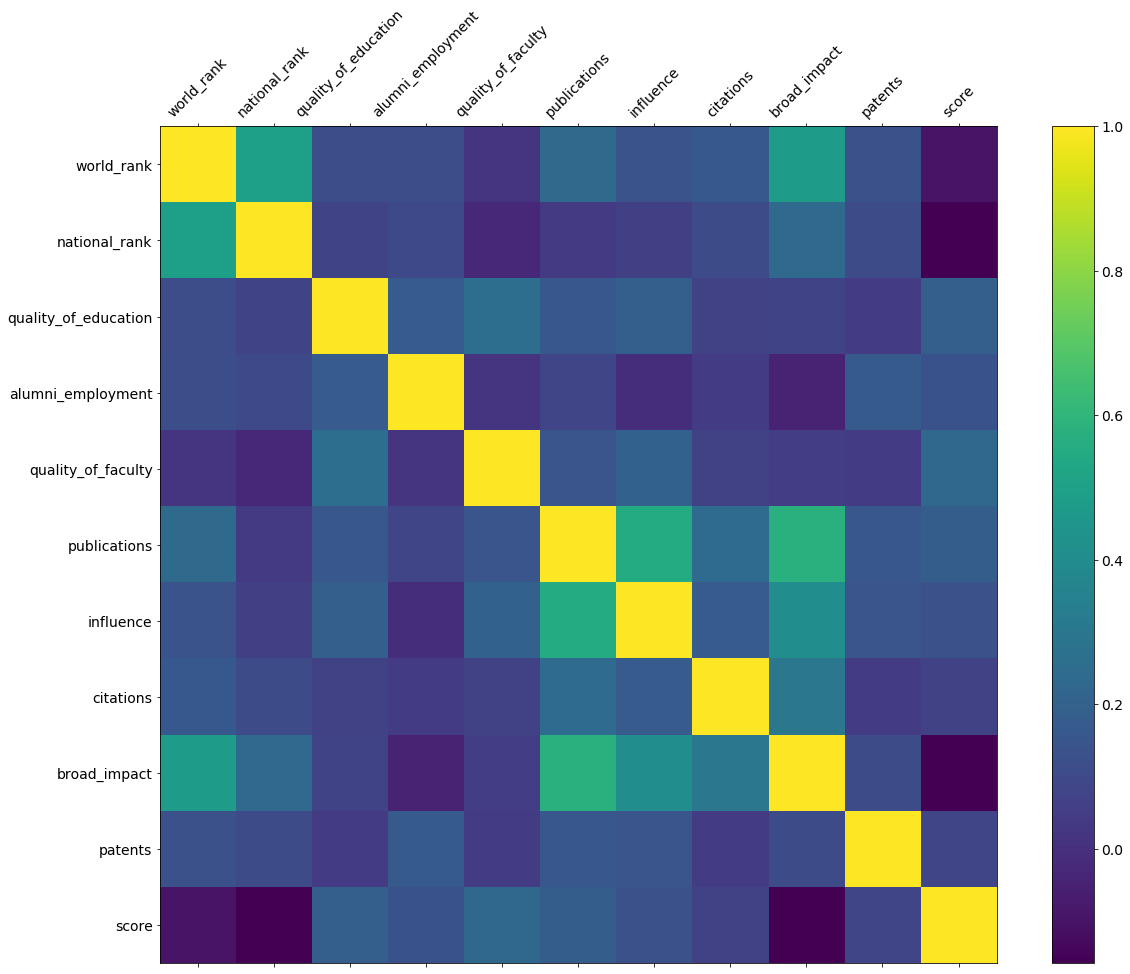

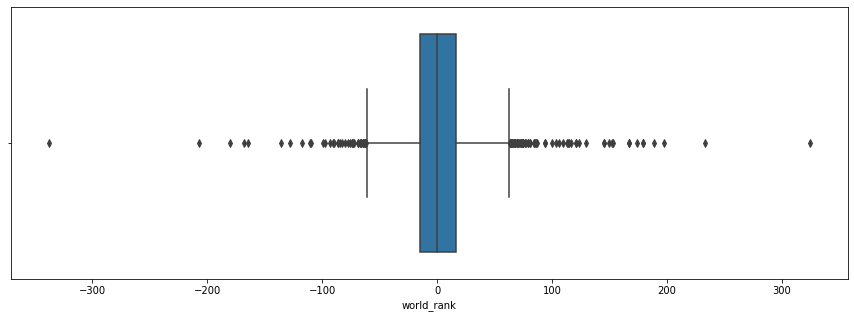

In [58]:
cwur_indexed = cwur_imputed.set_index(['year', 'institution'])


cwur_diff = cwur_indexed.groupby(by='institution').diff()


#Heatmap
fig1 = plt.figure(figsize=(20, 15))
plt.matshow(cwur_diff.corr(), fignum=fig1.number)
plt.xticks(range(cwur_diff.shape[1]), cwur_diff.columns, fontsize=14, rotation=45)
plt.yticks(range(cwur_diff.shape[1]), cwur_diff.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)


fig1 = plt.figure(figsize=(15, 5))
ax = sb.boxplot(x=cwur_diff['world_rank'])
cwur_diff



In [54]:


#reformat data so years are columns
hdi_ref = hdi.melt(id_vars=['HDI Rank', 'Country'], var_name='year', value_name='HDI')

hdi_ref['year'] = pd.to_numeric(hdi_ref['year'])


#rename columns for better readability
hdi_ref = hdi_ref.rename(columns={'Country': 'country', 'HDI Rank': 'hdi_rank', 'HDI':'hdi'})

#strip whitespace
hdi_ref['country'] = hdi_ref['country'].str.strip()
#set index
hdi_indexed = hdi_ref.set_index(['year', 'country'])
hdi_indexed = hdi_indexed.loc[(slice(2012, 2015))]

hdi_ref = hdi_indexed.reset_index()


In [7]:
#first we transform back our label encoding so we can merge

cwur_imputed['country'] = encCon.inverse_transform(cwur['country'])
cwur_imputed['institution'] = encInst.inverse_transform(cwur['institution'])

#in this step we merge with cwur_imputed data

#first check if  country names are different in both
country_check =  cwur_imputed[~cwur_imputed['country'].isin(hdi_ref['country'])]
print(country_check.country.unique())

#rename and replace names which don't match
#(no data for taiwan and puerto rico available)
country_dict = {"United States" : "USA",
                "Korea (Republic of)" : "South Korea",
                "Russian Federation" : "Russia",
                "Iran (Islamic Republic of)":"Iran",
                "Hong Kong, China (SAR)":"Hong Kong",
                "Czechia": "Czech Republic",
                "Slovakia" : "Slovak Republic"}
for key, value in country_dict.items():
    hdi_ref.replace(key, value, inplace=True)



#merge
cwur_hdi = pd.merge(cwur_imputed, hdi_ref, left_on=['year','country'], right_on = ['year','country'])


hdi_ref

['USA' 'South Korea' 'Russia' 'Taiwan' 'Hong Kong' 'Czech Republic'
 'Slovak Republic' 'Iran' 'Puerto Rico']


,year,country,hdi_rank,hdi
0,2012,Afghanistan,168,0.482
1,2012,Albania,68,0.767
2,2012,Algeria,85,0.740
3,2012,Andorra,35,0.849
4,2012,Angola,147,0.543
...,...,...,...,...
751,2015,Venezuela (Bolivarian Republic of),78,0.775
752,2015,Viet Nam,116,0.684
753,2015,Yemen,178,0.483
754,2015,Zambia,144,0.583


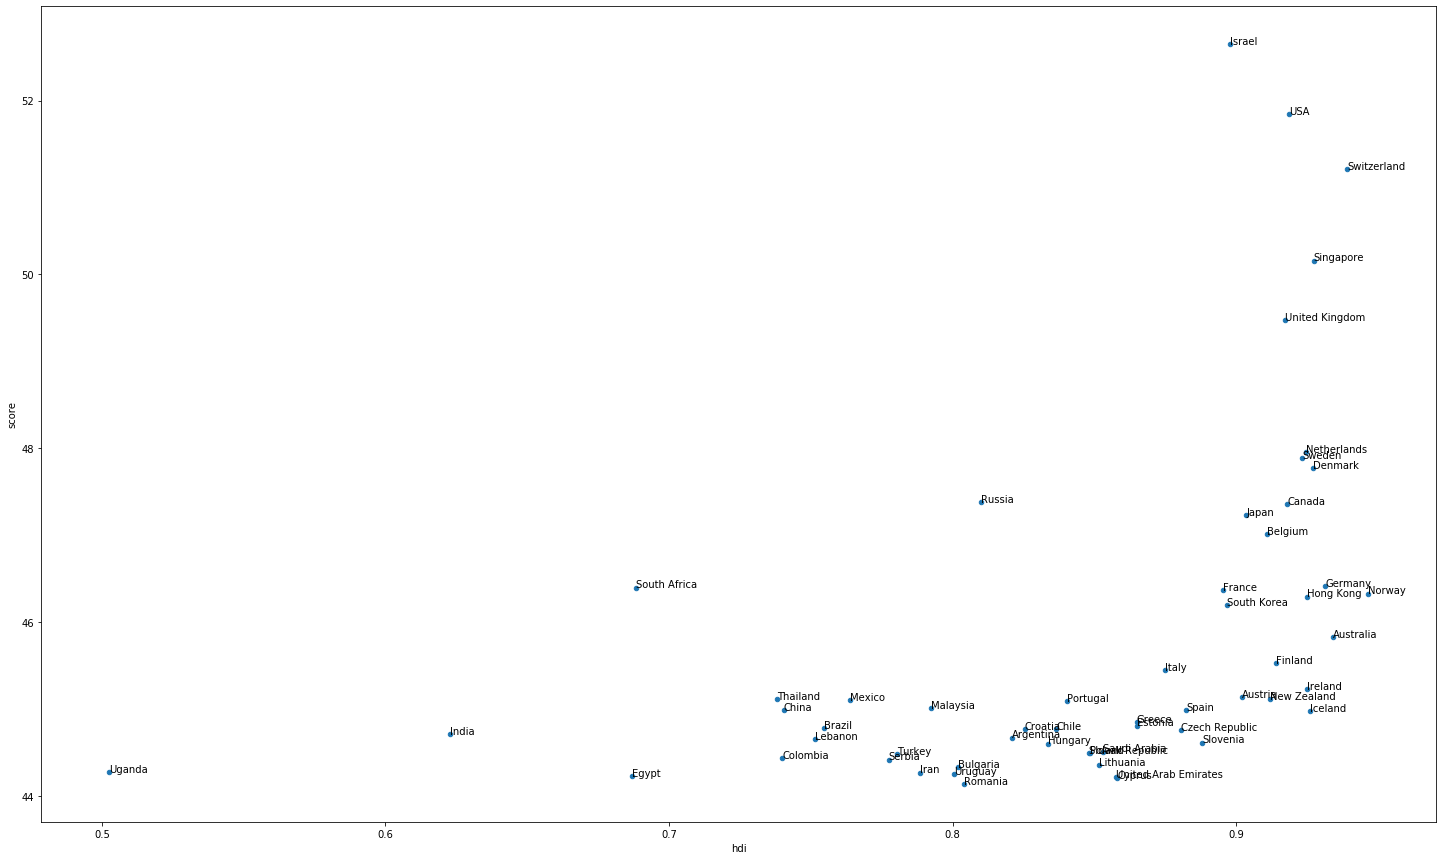

In [13]:
#check how HDI of countries correlates with rankings

#calculate mean world rank

cwur_hdi_mean = cwur_hdi.groupby("country").mean()

fig, ax = plt.subplots()
cwur_hdi_mean.plot("hdi", "score", kind="scatter",
             figsize = (25,15), ax=ax)

for k, v in cwur_hdi_mean.iterrows():
    x = v["hdi"]
    y = v["score"]
    ax.annotate(k, (x,y))
      
plt.show()


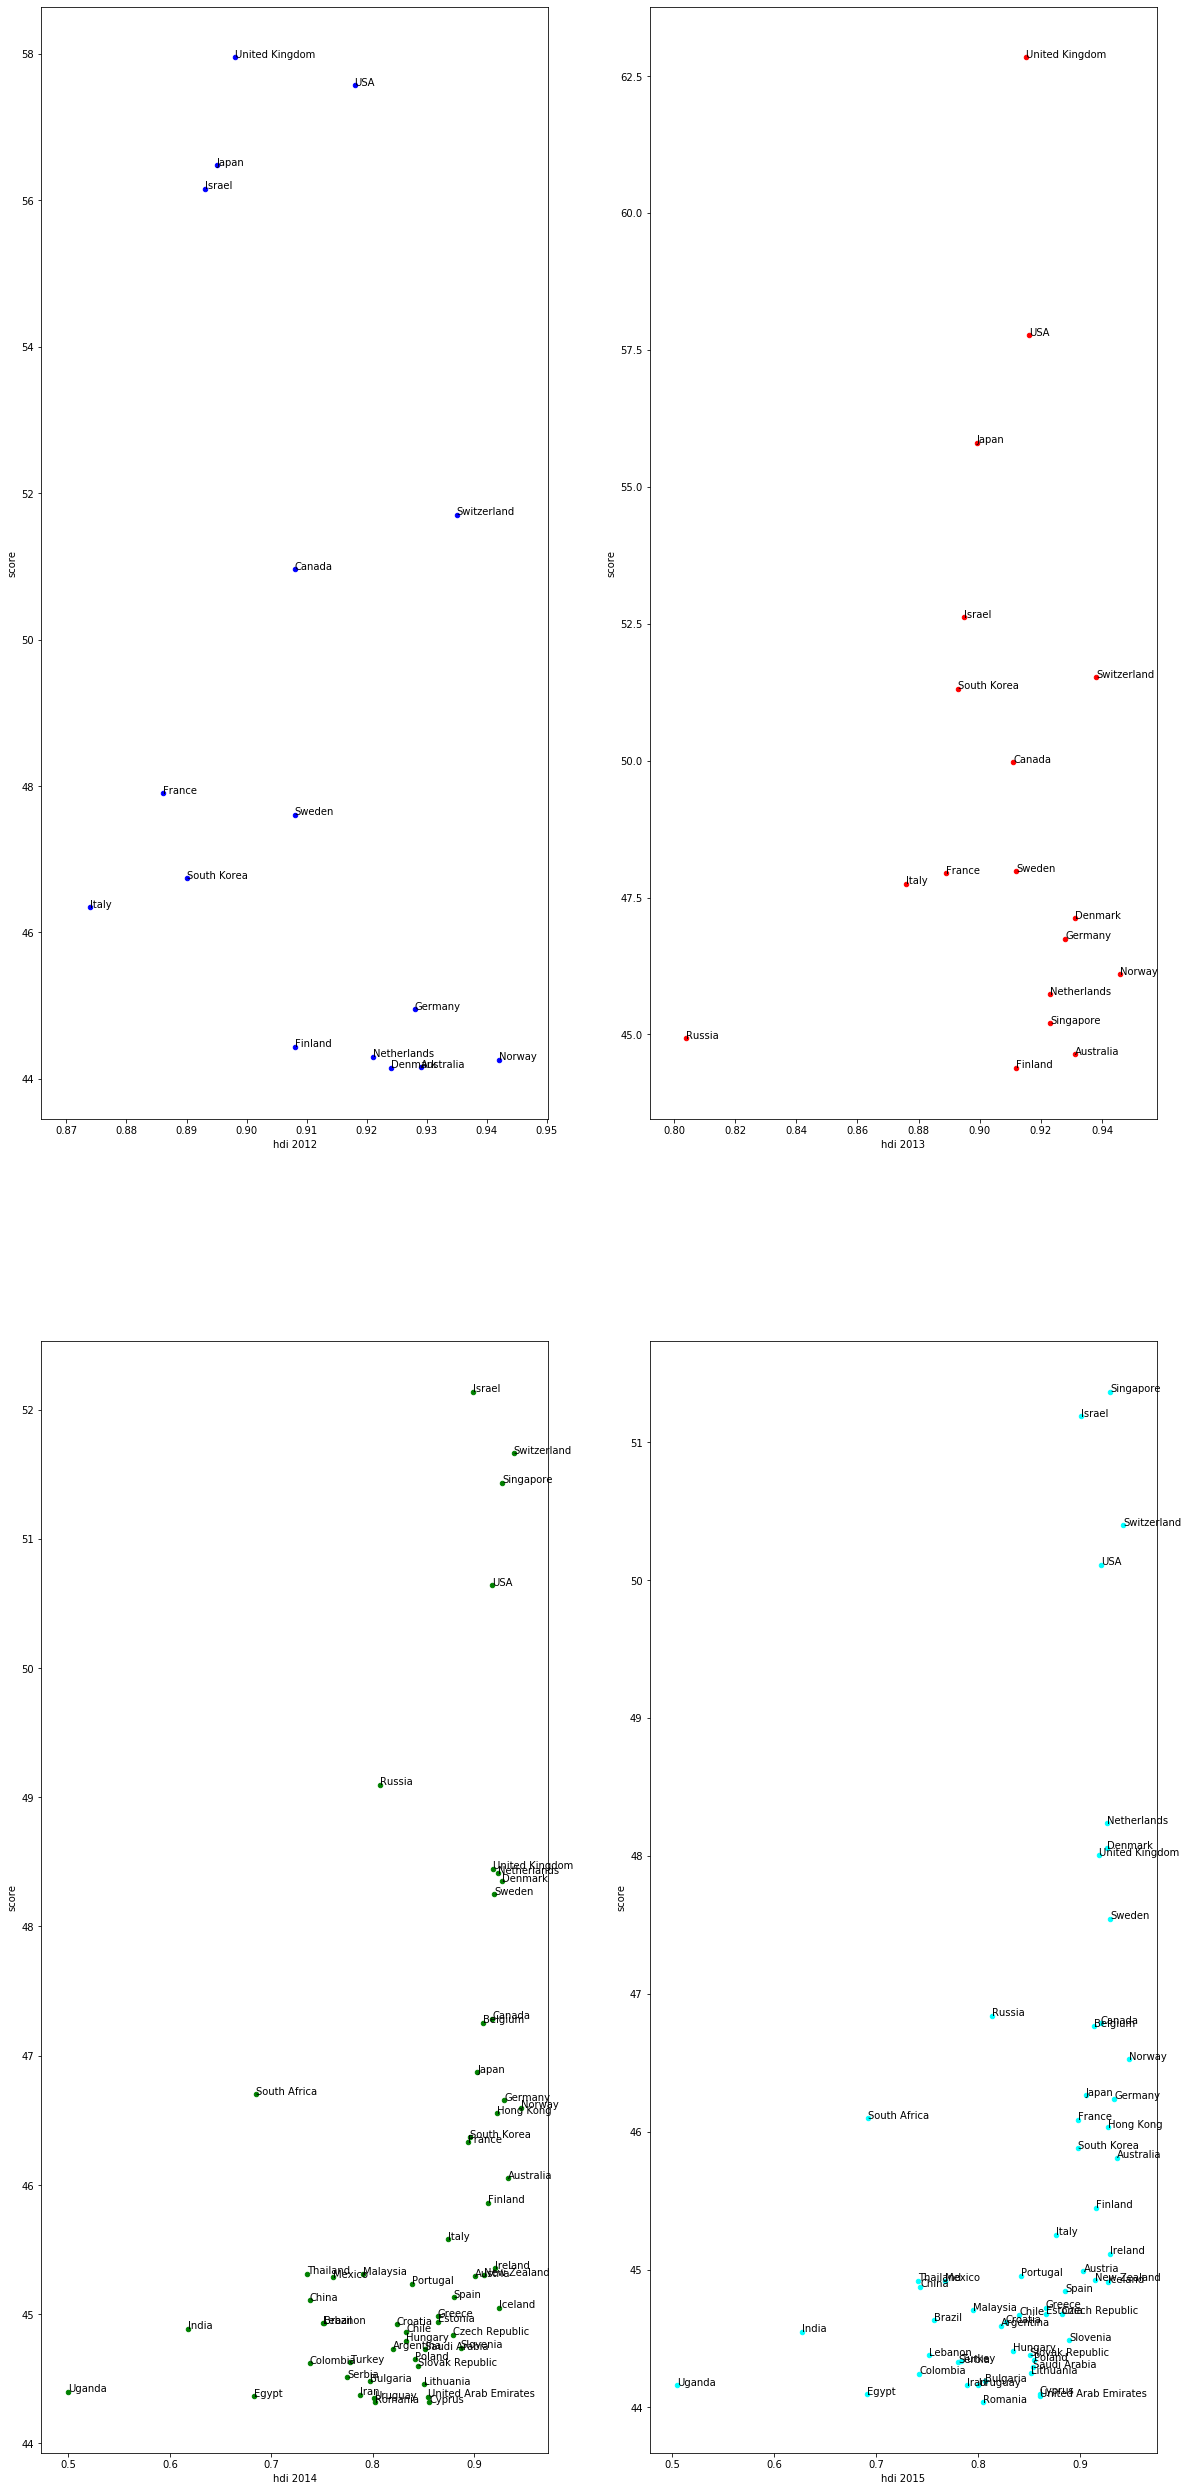

In [10]:
#check how HDI of countries correlates with rankings

#calculate mean world rank

cwur_hdi_mean = cwur_hdi.groupby(["year", "country"]).mean()
cwur_hdi_mean12 = cwur_hdi_mean.iloc[cwur_hdi_mean.index.get_level_values('year') == 2012.0]
cwur_hdi_mean13 = cwur_hdi_mean.iloc[cwur_hdi_mean.index.get_level_values('year') == 2013.0]
cwur_hdi_mean14 = cwur_hdi_mean.iloc[cwur_hdi_mean.index.get_level_values('year') == 2014.0]
cwur_hdi_mean15 = cwur_hdi_mean.iloc[cwur_hdi_mean.index.get_level_values('year') == 2015.0]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 45))
cwur_hdi_mean12.plot("hdi", "score", kind="scatter",
             figsize = figsize, ax=axs[0,0], color = "blue")
axs[0,0].set_xlabel("hdi 2012")


for k, v in cwur_hdi_mean12.iterrows():
    x = v["hdi"]
    y = v["score"]
    axs[0,0].annotate(k[1], (x,y))

cwur_hdi_mean13.plot("hdi", "score", kind="scatter",
             figsize = figsize, ax=axs[0,1], color = "red")
axs[0,1].set_xlabel("hdi 2013")
for k, v in cwur_hdi_mean13.iterrows():
    x = v["hdi"]
    y = v["score"]
    axs[0,1].annotate(k[1], (x,y))

cwur_hdi_mean14.plot("hdi", "score", kind="scatter",
             figsize = figsize, ax=axs[1,0], color = "green")
axs[1,0].set_xlabel("hdi 2014")
for k, v in cwur_hdi_mean14.iterrows():
    x = v["hdi"]
    y = v["score"]
    axs[1,0].annotate(k[1], (x,y))

cwur_hdi_mean15.plot("hdi", "score", kind="scatter",
             figsize = figsize, ax=axs[1,1], color = "cyan")
axs[1,1].set_xlabel("hdi 2015")
for k, v in cwur_hdi_mean15.iterrows():
    x = v["hdi"]
    y = v["score"]
    axs[1,1].annotate(k[1], (x,y))
    
    
plt.show()


In [33]:
cwur_hdi_indexed = cwur_hdi.set_index(['country', 'year'])
cwur_hdi_indexed

world_rank  \
country              year                 
USA                  2012.0         1.0   
                     2012.0         2.0   
                     2012.0         3.0   
                     2012.0         5.0   
                     2012.0         6.0   
...                                 ...   
Uganda               2015.0       869.0   
Cyprus               2015.0       928.0   
United Arab Emirates 2015.0       950.0   
Romania              2015.0       986.0   
                     2015.0       987.0   

                                                       institution  \
country              year                                            
USA                  2012.0                     Harvard University   
                     2012.0  Massachusetts Institute of Technology   
                     2012.0                    Stanford University   
                     2012.0     California Institute of Technology   
                     2012.0                   Princeton University   
...                                                            ...   
Uganda               2015.0                    Makerere University   
Cyprus               2015.0                   University of Cyprus   
United Arab Emirates 2015.0        United Arab Emirates University   
Romania              2015.0                University of Bucharest   
                     2015.0                Babeș-Bolyai University   

                             national_rank  quality_of_education  \
country              year                                          
USA                  2012.0            1.0                   7.0   
                     2012.0            2.0                   9.0   
                     2012.0            3.0                  17.0   
                     2012.0            4.0                   2.0   
                     2012.0            5.0                   8.0   
...                                    ...                   ...   
Uganda               2015.0            1.0                 367.0   
Cyprus               2015.0            1.0                 367.0   
United Arab Emirates 2015.0            1.0                 367.0   
Romania              2015.0            1.0                 237.0   
                     2015.0            2.0                 367.0   

                             alumni_employment  quality_of_faculty  \
country              year                                            
USA                  2012.0                9.0                 1.0   
                     2012.0               17.0                 3.0   
                     2012.0               11.0                 5.0   
                     2012.0               29.0                 7.0   
                     2012.0               14.0                 2.0   
...                                        ...                 ...   
Uganda               2015.0              567.0               218.0   
Cyprus               2015.0              567.0               218.0   
United Arab Emirates 2015.0              521.0               218.0   
Romania              2015.0              567.0               218.0   
                     2015.0              567.0               218.0   

                             publications  influence  citations  broad_impact  \
country              year                                                       
USA                  2012.0           1.0        1.0        1.0     18.044034   
                     2012.0          12.0        4.0        4.0     29.632996   
                     2012.0           4.0        2.0        2.0     28.800296   
                     2012.0          37.0       22.0       22.0     49.158332   
                     2012.0          53.0       33.0       26.0     55.961046   
...                                   ...        ...        ...           ...   
Uganda               2015.0         882.0      656.0      645.0    809.000000   
Cyprus               2015.0      

In [ ]:
#take countries with highest change over time